In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## Načítane údajov

In [2]:
measurements = pd.read_csv('measurements.csv', sep="\t")
measurements.head()

,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,longitude,CO,Pb,O3,latitude,PAHs,C2H3NO5,PM10,NH3,CH4
0,9.51360,41.03282,6.50135,32.66476,71.89902,6.79071,1199.30802,0.0,43.91385,10.87723,63.33747,10.13093,54.03876,9.35377,1.78025,7.94316,7.02427,4.87523
1,9.63498,27.94358,5.27514,4.33890,64.02148,6.37953,1068.23987,1.0,113.69785,7.40407,43.54337,9.45201,-7.73379,9.40390,1.35284,7.51350,9.02908,11.33912
2,9.78479,28.96943,5.63283,6.54628,71.06672,8.73821,1195.03374,1.0,14.39024,11.86258,33.50065,7.01922,42.22718,9.52245,0.46365,5.58768,6.30799,10.35857
3,9.95976,72.05699,6.28657,18.99498,58.38930,7.38700,1180.05312,1.0,126.28333,9.70606,82.14791,9.36236,45.35000,8.23922,4.35737,9.12098,7.55758,3.23723
4,9.84215,40.02949,7.79799,10.13795,72.36189,7.60453,1181.89445,1.0,-75.23266,6.40382,78.39028,9.99577,43.10090,7.86029,2.60066,8.34468,9.05060,6.82223


In [3]:
stations = pd.read_csv('stations.csv', sep="\t")
stations.head()

,location,station,longitude,latitude,revision,QoS
0,Africa/Lagos,Yenagoa,6.26764,4.92675,2014/01/15,excellent
1,Australia/Melbourne,Frankston South,145.13643,-38.16604,"11/08/2019, 00:00:00",excellent
2,Europe/Kiev,Nova Kakhovka,33.34864,46.75451,2014-10-22,average
3,Europe/Belgrade,Negotin,22.53083,44.22639,11 Jan 2017,average
4,America/Porto_Velho,Porto Velho,-63.90389,-8.76194,2013-02-02,excellent


Úprava dátomov na jednotný formát, aby sme s ním ďalej mohli pracovať

In [4]:
stations["revision"] = pd.to_datetime(stations.revision)
stations.head()

,location,station,longitude,latitude,revision,QoS
0,Africa/Lagos,Yenagoa,6.26764,4.92675,2014-01-15,excellent
1,Australia/Melbourne,Frankston South,145.13643,-38.16604,2019-11-08,excellent
2,Europe/Kiev,Nova Kakhovka,33.34864,46.75451,2014-10-22,average
3,Europe/Belgrade,Negotin,22.53083,44.22639,2017-01-11,average
4,America/Porto_Velho,Porto Velho,-63.90389,-8.76194,2013-02-02,excellent


Každá stanica má viacero meraní a v tabuľke measurements nie je údaj o tom, kedy bolo meranie vykonané, preto nedokážeme priradiť správne merania ku záznamom v tabuľke stanice. Aby sme ich mohli spojiť, zoradíme si záznamy v tabuľke stanice od najstaršieho po najnovšie a robíme iba s posledným. Výsledky by to nemalo ovplyvniť natoľko, aby ďalšia prácami s dátami nebola možná a správna.

In [5]:
stations = stations.sort_values("revision")
stations = stations.drop_duplicates(subset= 'station', keep = 'first')
stations.head()

,location,station,longitude,latitude,revision,QoS
609,America/Lima,Chosica,-76.70944,-11.94306,2012-10-06,excellent
465,Europe/Istanbul,Edremit,27.02444,39.59611,2012-10-13,excellent
520,Europe/Brussels,Beveren,4.25633,51.21187,2012-10-15,good
773,Asia/Tehran,Aleshtar,48.26258,33.86419,2012-10-20,good
1065,Asia/Krasnoyarsk,Lesosibirsk,92.48278,58.23583,2012-10-21,building


## Spojenie tabuliek

Tabuľky spojíme na základe zemepisnej šírky a výšky, ktoré sú jedinými spoločnými údjami.

In [6]:
spojene = pd.merge(stations, measurements, on = ['longitude', 'latitude'], how = "left")
spojene

,location,station,longitude,latitude,revision,QoS,SO2,H2CO,PM2.5,TEMP,...,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
0,America/Lima,Chosica,-76.70944,-11.94306,2012-10-06,excellent,9.31870,67.06773,10.48182,6.64406,...,1116.75371,0.0,8.66393,58.55564,7.02897,9.36955,1.28952,6.86463,8.99773,10.31581
1,America/Lima,Chosica,-76.70944,-11.94306,2012-10-06,excellent,9.82808,62.63766,5.96235,6.13766,...,1084.07360,0.0,8.05915,34.86132,10.31846,9.82826,1.05711,7.09442,8.60013,6.84385
2,America/Lima,Chosica,-76.70944,-11.94306,2012-10-06,excellent,10.21332,72.59743,10.09711,26.14160,...,1123.10562,0.0,8.05402,52.67786,6.38764,7.64631,0.82745,6.82192,9.50692,10.77657
3,America/Lima,Chosica,-76.70944,-11.94306,2012-10-06,excellent,11.06948,42.19244,8.08961,12.26261,...,1194.66625,1.0,11.20636,47.45721,9.51726,7.89218,0.81081,6.16463,9.13582,7.99058
4,America/Lima,Chosica,-76.70944,-11.94306,2012-10-06,excellent,9.03928,29.02164,5.81570,17.47810,...,1064.89633,1.0,6.79811,45.16225,11.67839,9.69349,3.34577,8.90648,8.38306,11.21220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12100,America/Chicago,Kaukauna,-88.27205,44.27804,2022-08-30,accep,11.09755,40.70058,6.65984,11.96652,...,1097.53464,0.0,4.47893,64.71063,5.98089,6.48181,0.68702,3.68971,8.41234,7.99304
12101,America/Chicago,Kaukauna,-88.27205,44.27804,2022-08-30,accep,8.36313,41.73999,8.40068,11.65424,...,1150.50122,0.0,10.90475,58.10251,10.15560,8.07576,2.33573,8.20884,7.96797,7.02609
12102,America/Chicago,Kaukauna,-88.27205,44.27804,2022-08-30,accep,10.35859,59.96362,6.38821,19.31148,...,1110.05684,1.0,10.94066,34.64128,7.30591,8.10712,0.61396,5.33483,7.89450,9.59599
12103,America/Chicago,Kaukauna,-88.27205,44.27804,2022-08-30,accep,10.19640,32.63680,7.85045,10.82795,...,1164.99345,1.0,8.19147,47.44577,11.39712,7.51582,13.93203,10.40692,6.38187,10.01874


## Premena na číslené hodnoty

In [7]:
spojene.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12105 entries, 0 to 12104
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   location   12105 non-null  object        
 1   station    12105 non-null  object        
 2   longitude  12105 non-null  float64       
 3   latitude   12105 non-null  float64       
 4   revision   12105 non-null  datetime64[ns]
 5   QoS        12105 non-null  object        
 6   SO2        12055 non-null  float64       
 7   H2CO       12055 non-null  float64       
 8   PM2.5      12056 non-null  float64       
 9   TEMP       12056 non-null  float64       
 10  CFCs       12056 non-null  float64       
 11  NOx        12055 non-null  float64       
 12  PRES       12105 non-null  float64       
 13  warning    12056 non-null  float64       
 14  CO         12055 non-null  float64       
 15  Pb         12056 non-null  float64       
 16  O3         12055 non-null  float64      

Údaje o stanici,lokácii a  QoS vymažeme, lebo ich nevieme previesť na číselnú hodnotu. Výsledky by to nemalo ovplyvniť, keďže predikujeme hodnotu warningu, na čo nám údaje o názve mieste merania a hodntenia nie sú potrebné

In [8]:
spojene = spojene.drop(['location','station', 'QoS'], axis=1)
spojene.head()

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
0,-76.70944,-11.94306,2012-10-06,9.31870,67.06773,10.48182,6.64406,67.65873,8.74249,1116.75371,0.0,8.66393,58.55564,7.02897,9.36955,1.28952,6.86463,8.99773,10.31581
1,-76.70944,-11.94306,2012-10-06,9.82808,62.63766,5.96235,6.13766,68.06072,6.25434,1084.07360,0.0,8.05915,34.86132,10.31846,9.82826,1.05711,7.09442,8.60013,6.84385
2,-76.70944,-11.94306,2012-10-06,10.21332,72.59743,10.09711,26.14160,62.76016,9.21749,1123.10562,0.0,8.05402,52.67786,6.38764,7.64631,0.82745,6.82192,9.50692,10.77657
3,-76.70944,-11.94306,2012-10-06,11.06948,42.19244,8.08961,12.26261,83.72481,9.15984,1194.66625,1.0,11.20636,47.45721,9.51726,7.89218,0.81081,6.16463,9.13582,7.99058
4,-76.70944,-11.94306,2012-10-06,9.03928,29.02164,5.81570,17.47810,65.29552,10.12011,1064.89633,1.0,6.79811,45.16225,11.67839,9.69349,3.34577,8.90648,8.38306,11.21220


Premena dátumu na int

In [9]:
spojene.revision = pd.to_numeric(spojene["revision"],downcast="integer")
spojene.head()

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
0,-76.70944,-11.94306,1349481600000000000,9.31870,67.06773,10.48182,6.64406,67.65873,8.74249,1116.75371,0.0,8.66393,58.55564,7.02897,9.36955,1.28952,6.86463,8.99773,10.31581
1,-76.70944,-11.94306,1349481600000000000,9.82808,62.63766,5.96235,6.13766,68.06072,6.25434,1084.07360,0.0,8.05915,34.86132,10.31846,9.82826,1.05711,7.09442,8.60013,6.84385
2,-76.70944,-11.94306,1349481600000000000,10.21332,72.59743,10.09711,26.14160,62.76016,9.21749,1123.10562,0.0,8.05402,52.67786,6.38764,7.64631,0.82745,6.82192,9.50692,10.77657
3,-76.70944,-11.94306,1349481600000000000,11.06948,42.19244,8.08961,12.26261,83.72481,9.15984,1194.66625,1.0,11.20636,47.45721,9.51726,7.89218,0.81081,6.16463,9.13582,7.99058
4,-76.70944,-11.94306,1349481600000000000,9.03928,29.02164,5.81570,17.47810,65.29552,10.12011,1064.89633,1.0,6.79811,45.16225,11.67839,9.69349,3.34577,8.90648,8.38306,11.21220


In [10]:
spojene = spojene.drop_duplicates()

## Chýbajúce hodnoty

1. Keďže hodnoty stĺpca warning môžu mať iba hodnotu 1 alebo 0 nemôžeme ich nahradiť inými hodnotami ako priemer alebo medián. Nemôžeme ani zvoliť náhodne jednu hodnotu, lebo by to skreslilo analýzu, preto záznamy,  kde sa údaje o warningu nenachádzajú, vymažeme

In [11]:
spojene = spojene.dropna(subset=['warning'])

In [12]:
x = pd.isna(spojene['warning'])
x.sum()

0

2. V iných stĺpcoch, kde chýbajú údaje, ich zaplníme priemerom stĺpca

In [13]:
spojene[spojene.isnull().any(axis=1)]

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
6,-76.70944,-11.94306,1349481600000000000,8.41189,53.69719,8.04356,8.54123,57.83275,7.83278,1063.20695,1.0,9.24888,40.70356,8.99147,NaN,1.02232,7.01125,8.73412,9.41984
21,-76.70944,-11.94306,1349481600000000000,9.91067,71.62305,7.04730,-2.05966,NaN,8.79024,1134.16643,1.0,10.45783,52.04425,9.51667,8.70449,0.32265,5.97870,7.28443,9.02938
52,4.25633,51.21187,1350259200000000000,7.35901,52.78339,8.25774,35.86911,77.19379,7.57845,1097.71238,1.0,9.49412,NaN,11.12409,7.16679,7.92196,9.78613,8.09292,5.24635
53,4.25633,51.21187,1350259200000000000,8.48308,51.01521,NaN,24.37297,65.98064,9.44528,1120.66258,1.0,10.62262,59.57528,7.55547,8.50013,0.65787,5.43632,7.79121,9.48874
65,48.26258,33.86419,1350691200000000000,11.82555,61.93591,4.92697,NaN,82.99136,7.03177,1052.94414,1.0,10.09883,53.35827,9.46689,6.31750,2.99601,8.59769,9.78894,11.14754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12027,88.14530,22.47110,1660780800000000000,8.40363,50.70142,7.50055,8.63009,66.66239,9.22736,1066.75738,0.0,NaN,53.47327,10.60136,8.16973,2.06252,7.90575,9.55544,7.90723
12034,88.14530,22.47110,1660780800000000000,10.15064,NaN,4.86700,21.57074,75.01479,9.70486,1083.59372,0.0,7.95491,34.02853,11.11783,8.41888,0.89359,6.55587,7.71964,5.49163
12044,34.37389,40.16750,1661126400000000000,NaN,45.01881,7.69311,4.28908,83.11890,9.26149,1074.09460,1.0,10.21884,62.64391,10.99402,9.82184,0.97535,6.06168,7.06372,7.76812
12060,35.34722,-23.85972,1661299200000000000,8.49003,76.94334,5.85430,7.85994,NaN,8.23508,1105.01179,1.0,7.45977,66.71911,10.93848,8.48016,2.02747,7.83432,8.80784,7.05778


In [14]:
spojene = spojene.fillna(spojene.mean())

In [15]:
spojene.isnull().sum()

longitude    0
latitude     0
revision     0
SO2          0
H2CO         0
PM2.5        0
TEMP         0
CFCs         0
NOx          0
PRES         0
warning      0
CO           0
Pb           0
O3           0
PAHs         0
C2H3NO5      0
PM10         0
NH3          0
CH4          0
dtype: int64

## Vychýlené hodnoty

Odstránenie vychýlených hodnôt sme vyskúšali dvoma spôsbmi.
1. Vymazzaním hraninčých hodnôt
2. Nahradením hraničných hodnôt

Pre porovanie graf pred vymazaním hraničných hodnôt

<AxesSubplot: ylabel='C2H3NO5'>

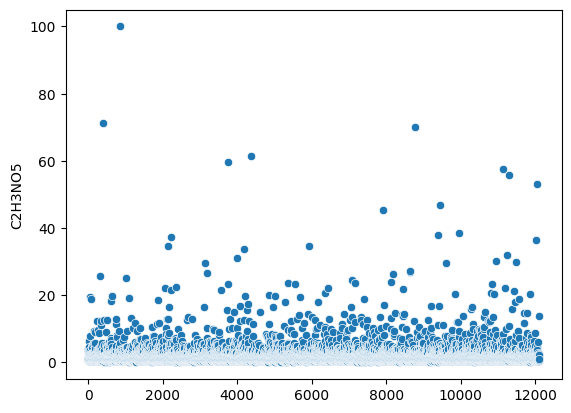

In [16]:
sns.scatterplot(spojene.C2H3NO5)

Prvým je vymazanie vychýlených hodnôt pomocou IQR metódy, kedy záznamy vymažeme z datasetu úplne

In [17]:
spojene1 = spojene
Q1 = spojene.quantile(0.25)
Q3 = spojene.quantile(0.75)
IQR = Q3 - Q1
((spojene < (Q1 - 1.5 * IQR)) | (spojene > (Q3 + 1.5 * IQR))).sum()
condition = ~((spojene < (Q1 - 1.5 * IQR)) | (spojene > (Q3 + 1.5 * IQR))).any(axis=1)

spojene1 = spojene[condition]
spojene1

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
0,-76.70944,-11.94306,1349481600000000000,9.31870,67.06773,10.48182,6.64406,67.65873,8.74249,1116.75371,0.0,8.66393,58.55564,7.02897,9.369550,1.28952,6.86463,8.99773,10.31581
1,-76.70944,-11.94306,1349481600000000000,9.82808,62.63766,5.96235,6.13766,68.06072,6.25434,1084.07360,0.0,8.05915,34.86132,10.31846,9.828260,1.05711,7.09442,8.60013,6.84385
2,-76.70944,-11.94306,1349481600000000000,10.21332,72.59743,10.09711,26.14160,62.76016,9.21749,1123.10562,0.0,8.05402,52.67786,6.38764,7.646310,0.82745,6.82192,9.50692,10.77657
3,-76.70944,-11.94306,1349481600000000000,11.06948,42.19244,8.08961,12.26261,83.72481,9.15984,1194.66625,1.0,11.20636,47.45721,9.51726,7.892180,0.81081,6.16463,9.13582,7.99058
6,-76.70944,-11.94306,1349481600000000000,8.41189,53.69719,8.04356,8.54123,57.83275,7.83278,1063.20695,1.0,9.24888,40.70356,8.99147,8.318872,1.02232,7.01125,8.73412,9.41984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,-88.27205,44.27804,1661817600000000000,9.32973,65.97289,5.66222,23.24615,80.41314,8.64322,1160.27549,0.0,9.40330,47.74427,10.84195,7.889220,0.81440,6.42695,7.32203,7.08387
12100,-88.27205,44.27804,1661817600000000000,11.09755,40.70058,6.65984,11.96652,74.19792,9.01184,1097.53464,0.0,4.47893,64.71063,5.98089,6.481810,0.68702,3.68971,8.41234,7.99304
12101,-88.27205,44.27804,1661817600000000000,8.36313,41.73999,8.40068,11.65424,72.52207,8.13900,1150.50122,0.0,10.90475,58.10251,10.15560,8.075760,2.33573,8.20884,7.96797,7.02609
12102,-88.27205,44.27804,1661817600000000000,10.35859,59.96362,6.38821,19.31148,66.16492,7.32417,1110.05684,1.0,10.94066,34.64128,7.30591,8.107120,0.61396,5.33483,7.89450,9.59599


Druhý spôsob je odstránenie vychýlených hodnôt,ktoré funguje na princípe ich nahradenia hraničnými hodnotami rozdelenia.

In [18]:
def replace(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    dolny_interval = data[column] < (Q1 - 1.5 * IQR)
    horny_interval = data[column] > (Q3 + 1.5 * IQR)
    
    data.loc[horny_interval, column] = Q3
    data.loc[dolny_interval, column] = Q1
    return data
    

In [19]:
spojene2 = spojene
spojene2 = replace(spojene,"longitude")
spojene2 = replace(spojene,"latitude")
spojene2 = replace(spojene,"revision")
spojene2 = replace(spojene,"C2H3NO5")
spojene2 = replace(spojene,"SO2")
spojene2 = replace(spojene,"H2CO")
spojene2 = replace(spojene,"PM2.5")
spojene2 = replace(spojene,"TEMP")
spojene2 = replace(spojene,"CFCs")
spojene2 = replace(spojene,"NOx")
spojene2 = replace(spojene,"O3")
spojene2 = replace(spojene,"PAHs")
spojene2 = replace(spojene,"PM10")
spojene2 = replace(spojene,"O3")
spojene2 = replace(spojene,"CH4")
spojene2 = replace(spojene,"NH3")
spojene2 = replace(spojene,"PRES")
spojene2 = replace(spojene,"CO")
spojene2 = replace(spojene,"Pb")

Porovnanie grafu po vymazaní hraničných hodnôt

<AxesSubplot: ylabel='C2H3NO5'>

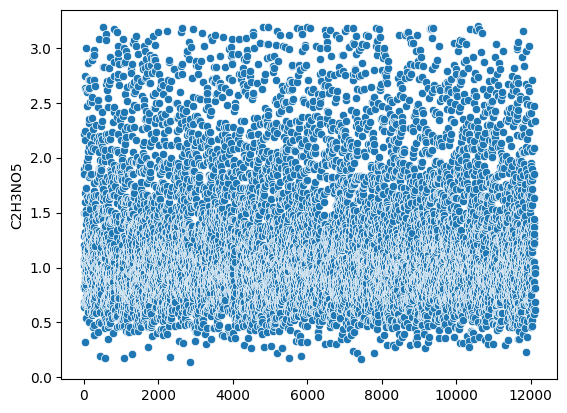

In [20]:
sns.scatterplot(spojene1.C2H3NO5)

<AxesSubplot: ylabel='C2H3NO5'>

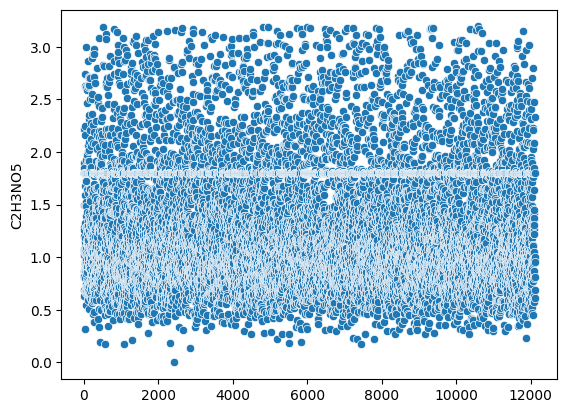

In [21]:
sns.scatterplot(spojene2.C2H3NO5)

In [22]:
((spojene1 < (Q1 - 1.5 * IQR)) | (spojene1 > (Q3 + 1.5 * IQR))).sum()

longitude    0
latitude     0
revision     0
SO2          0
H2CO         0
PM2.5        0
TEMP         0
CFCs         0
NOx          0
PRES         0
warning      0
CO           0
Pb           0
O3           0
PAHs         0
C2H3NO5      0
PM10         0
NH3          0
CH4          0
dtype: int64

In [23]:
((spojene2 < (Q1 - 1.5 * IQR)) | (spojene2 > (Q3 + 1.5 * IQR))).sum()

longitude    0
latitude     0
revision     0
SO2          0
H2CO         0
PM2.5        0
TEMP         0
CFCs         0
NOx          0
PRES         0
warning      0
CO           0
Pb           0
O3           0
PAHs         0
C2H3NO5      0
PM10         0
NH3          0
CH4          0
dtype: int64

Porovnanie základných štatistických údaajov. Môžeme si všimnúť, že sa výrazne nelíšia, okrem počtu záznamov. Väčšie výchylky sú iba pri zemepisnej výške a šírke, keďže tam boli najviac vychýlené hodnoty, ale merania sa líšia iba o desatiné miesta

In [24]:
spojene1.describe()

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
count,9553.00000,9553.000000,9.553000e+03,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000,9553.000000
mean,9.22025,32.561946,1.457544e+18,9.641571,50.100960,7.483202,14.990682,72.665586,8.320008,1124.607279,0.592170,8.317298,50.504154,8.985867,8.320675,1.262351,6.799472,8.319565,8.241980
std,72.63266,18.689766,8.061697e+16,1.104464,12.289172,1.679799,9.668891,6.936126,0.972300,43.390464,0.491457,2.082022,12.894688,1.577439,0.973040,0.587450,1.096387,0.978568,1.750415
min,-123.02621,-22.573060,1.349482e+18,6.553590,15.984910,2.698980,-11.509560,53.347620,5.647980,1050.007790,0.000000,2.459900,15.627150,4.543920,5.649190,0.136030,3.467160,5.611520,2.819260
25%,-71.05977,21.465270,1.387238e+18,8.917460,41.720530,6.317300,8.336200,67.815700,7.651950,1086.812610,0.000000,6.859810,41.768360,7.927350,7.656520,0.845330,6.063350,7.642650,6.957060
50%,9.72749,36.821670,1.439597e+18,9.619914,50.149550,7.429480,14.951158,72.660653,8.316900,1124.595670,1.000000,8.426970,50.442856,9.106880,8.320190,1.107110,6.879590,8.318480,8.243820
75%,72.34424,45.991940,1.509754e+18,10.376810,58.585890,8.657820,21.613500,77.461250,8.988450,1162.364910,1.000000,9.839930,59.292100,10.104020,8.982620,1.536960,7.642660,8.991090,9.542090
max,168.31366,65.848110,1.661818e+18,12.712070,84.323960,12.260170,41.865500,91.969290,10.994270,1199.949340,1.000000,14.268450,85.360760,13.673490,10.959410,3.193660,9.915020,11.019190,13.763750


In [25]:
spojene2.describe()

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
count,11878.000000,11878.000000,1.187800e+04,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000
mean,10.056336,32.044646,1.458611e+18,9.625686,50.146867,7.543332,14.973802,72.653511,8.319818,1124.425067,0.592271,8.344245,50.475004,9.084827,8.317939,1.306870,7.016360,8.320057,8.316934
std,73.626188,18.593706,8.111206e+16,1.130881,12.279688,1.739275,9.663459,6.928274,0.969370,43.461073,0.491433,2.074998,12.785742,1.639718,0.971206,0.579040,1.288428,0.976357,1.853989
min,-123.026210,-22.573060,1.349482e+18,6.553590,15.984910,2.698980,-11.945040,53.347620,5.647980,1050.007790,0.000000,2.459900,15.576640,4.543920,5.649190,0.000000,3.467160,5.611520,2.819260
25%,-65.718750,18.208540,1.387498e+18,8.857261,41.619265,6.317982,8.198984,67.799501,7.651944,1086.713880,0.000000,6.890947,41.773919,7.967837,7.647222,0.869387,6.121894,7.639231,6.941992
50%,9.850000,36.330110,1.440202e+18,9.619914,50.243595,7.466580,14.951158,72.660653,8.318090,1124.208775,1.000000,8.423565,50.401165,9.182795,8.318872,1.164500,7.017657,8.319515,8.314380
75%,72.939240,45.530690,1.510531e+18,10.402783,58.711527,8.732440,21.688550,77.476581,8.990081,1162.097200,1.000000,9.859093,59.257595,10.254074,8.985829,1.800994,7.914630,8.991604,9.704094
max,178.004170,65.848110,1.661818e+18,12.712070,84.323960,12.328360,41.865500,91.969290,10.994270,1199.975590,1.000000,14.282520,85.360760,13.675280,10.969250,3.193660,10.601900,11.019190,13.842480


In [26]:
spojene = spojene2

Druhý spôsob je pre našu analýzu dát lepší, keďže pri ňom neprichádzame o žiadne dáta

## Rozdelenie datasetu 

Rozdelili sme si dataset na trénovaciu a testovaciu časť v pomere 7:3. 

In [27]:
train, test = train_test_split(spojene,test_size=0.3, train_size=0.7) #,shuffle=False

In [28]:
train.head()

,longitude,latitude,revision,SO2,H2CO,PM2.5,TEMP,CFCs,NOx,PRES,warning,CO,Pb,O3,PAHs,C2H3NO5,PM10,NH3,CH4
7426,-86.19903,11.84962,1467158400000000000,7.67570,54.21292,10.85348,9.23386,72.17775,6.81180,1059.05874,0.0,11.76531,56.41301,8.42771,7.40256,1.801052,8.96928,9.05772,8.29246
8573,-73.86586,45.43341,1500249600000000000,9.80022,38.25011,6.37502,16.92557,78.84746,10.92045,1052.87153,1.0,6.60849,46.95141,10.25984,6.89639,0.858540,6.77045,7.99892,7.53100
11959,-82.90375,32.54044,1655078400000000000,9.36434,40.91275,8.04568,18.29829,69.64430,7.88946,1084.03724,1.0,7.40029,41.78090,9.36174,7.48948,2.608550,8.58040,8.64983,6.04674
8203,-85.76942,39.78504,1488326400000000000,7.52418,63.74812,7.09704,0.35568,85.08233,10.09125,1128.07234,1.0,10.09246,28.39471,8.23212,9.52975,0.810250,5.80837,9.23512,9.90770
2173,-37.65000,-10.91722,1380153600000000000,8.92396,49.84812,6.46454,24.61143,67.99779,9.49466,1088.99437,0.0,8.76243,67.90549,8.56498,8.81510,0.910580,5.93435,9.16703,6.54341


# Transformácia dát

Dáta sme transformovali:
1. škálovaním
2. normalizáciou

## Škálovanie

Dáta pred škálovaním

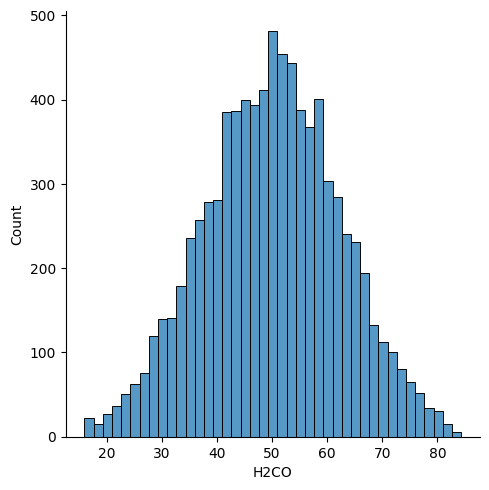

In [29]:
sns.displot(train.H2CO)

Na škálovanie sme použili MinMax metódu, ktorá je pre náš prípad vhodnejšia v porovnaní so Standart,  keďže tu  už z prvej fázy vieme, že dáta nie sú normálne distribuované

In [30]:
min_max_scaler = MinMaxScaler()
scaled = min_max_scaler.fit_transform(train)
print(scaled)

[[0.12233709 0.3893036  0.37676349 ... 0.77120559 0.63728001 0.49651554]
 [0.16330694 0.76911977 0.48271093 ... 0.46300621 0.44148404 0.42743772]
 [0.13328376 0.62330661 0.97842324 ... 0.71669816 0.56185196 0.29278922]
 ...
 [0.86326194 0.64527941 0.3197787  ... 0.40841047 0.85305316 0.6070268 ]
 [0.35686169 0.40872259 0.02351314 ... 0.9390702  0.36724874 0.74815707]
 [0.40207453 0.31527393 0.28990318 ... 0.34424566 0.39735043 0.58514753]]


Funkcia MinMax vracia Array, potrebujeme dáta pretransformovať naspäť na dataframe, aby sme s ním mohli ďalej pracovať

In [31]:
train_s=pd.DataFrame(scaled)
train_s.columns=train.columns.copy()

Dáta po škálovaní

Na x-ovej osi je možné vidieť, ako sa zmenili dáta. Takto úpravené (na hodnoty v rozsahu od 0 po 1) sú upravené všetky dáta, aby sa nám s nimi v ďalšej fáze lepšie pracovalo a nemali všetky hodnoty rozdielny rozsah

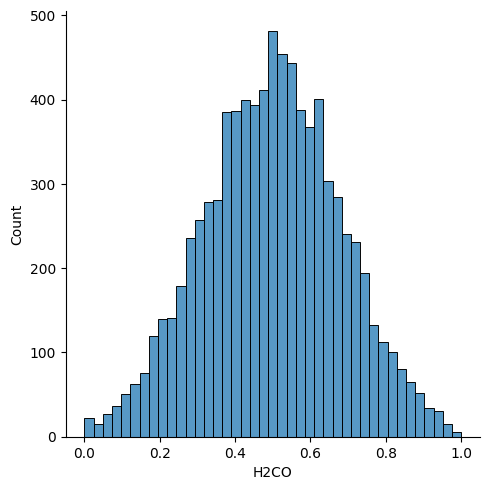

In [32]:
sns.displot(train_s['H2CO'])

## Normalizácia

Chceme upraviť dáta, aby boli čo najviac z normálnej distribúcie,  keďže je to predpoklad pre niektoré algoritmy v strojovom učení a aj keď to nie je potrebné, pracuje sa s takými dátami lepšie a výsledky sú presnejšie. Takéto sme upravili v:
1. longitude
2. latitude
3. revision
4. C2H3NO5

Graf pred úpravou

((array([-3.7647209 , -3.53698593, -3.4118362 , ...,  3.4118362 ,
          3.53698593,  3.7647209 ]),
  array([0.        , 0.05376903, 0.05422932, ..., 0.99818077, 0.99940507,
         1.        ])),
 (0.1759330653145547, 0.4101031609237665, 0.9694108942791289))

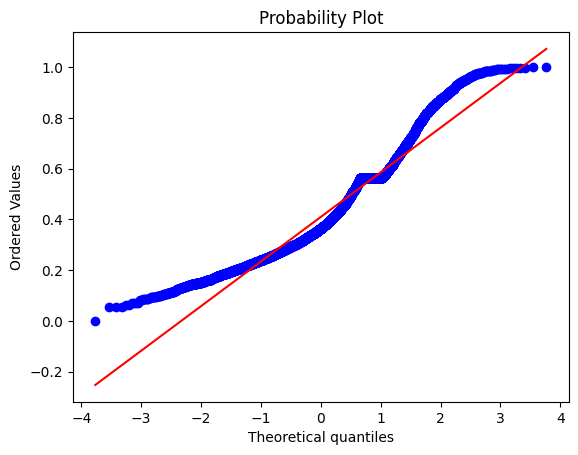

In [33]:
stats.probplot(train_s["C2H3NO5"], plot=sns.mpl.pyplot, fit=True)

Použili sme funkciu Power transform na úpravu dát, konkrétne metódu yeo-johnson. Metódu box-cox sme nemohli použiť, keďže sa u nás vyskytujú aj záporné hodnoty

In [34]:
power = PowerTransformer(standardize=False)
train_s["C2H3NO5"] = power.fit_transform(train_s["C2H3NO5"].values.reshape(-1, 1))

Graf po úprave

((array([-3.7647209 , -3.53698593, -3.4118362 , ...,  3.4118362 ,
          3.53698593,  3.7647209 ]),
  array([-0.        ,  0.04971066,  0.05010356, ...,  0.37375255,
          0.37390479,  0.37397867])),
 (0.06056338271959923, 0.23658806427881884, 0.993282457005628))

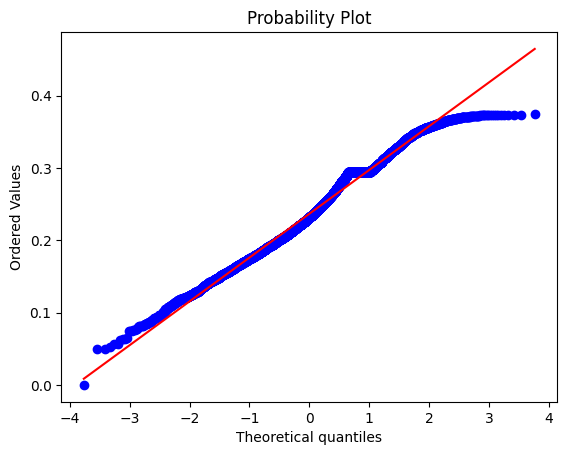

In [35]:
stats.probplot(train_s["C2H3NO5"], plot=sns.mpl.pyplot, fit=True)

In [36]:
train_s["longitude"] = power.fit_transform(train_s["longitude"].values.reshape(-1, 1))
train_s["latitude"] = power.fit_transform(train_s["latitude"].values.reshape(-1, 1))
train_s["revision"] = power.fit_transform(train_s["revision"].values.reshape(-1, 1))
train = train_s

## Výber atribútov pre strojové učenie

Na výber atribútov sme použili funkciu SelecFromModel. Vstupom je atribút, o ktorom chceme zisitiť - warning, ktoré ho ovplyvňujú a tabuľka s ostatnými atribútmi, o ktorých chceme zistiť, či na warning majú nejaký vplyv

In [37]:
data_input = train_s.copy()
data_input.drop('warning',axis='columns',inplace=True)

In [38]:
selector= SelectFromModel(estimator=LogisticRegression()).fit(data_input,train_s["warning"])
selector_coef=selector.estimator_.coef_

p=0
for i in selector.get_support():
    print(data_input.columns[p] + " " + str(i))
    if i:
        print(abs(selector.estimator_.coef_[0][p]))
    else:
        print("Atribút nemá vplyv na warning")
    print()
    p+=1

longitude False
Atribút nemá vplyv na warning

latitude False
Atribút nemá vplyv na warning

revision False
Atribút nemá vplyv na warning

SO2 False
Atribút nemá vplyv na warning

H2CO False
Atribút nemá vplyv na warning

PM2.5 True
2.7489160836405793

TEMP False
Atribút nemá vplyv na warning

CFCs False
Atribút nemá vplyv na warning

NOx False
Atribút nemá vplyv na warning

PRES False
Atribút nemá vplyv na warning

CO False
Atribút nemá vplyv na warning

Pb False
Atribút nemá vplyv na warning

O3 True
3.9983864619878546

PAHs False
Atribút nemá vplyv na warning

C2H3NO5 False
Atribút nemá vplyv na warning

PM10 False
Atribút nemá vplyv na warning

NH3 False
Atribút nemá vplyv na warning

CH4 True
1.7905233534259712



Z toho nám vyplýva, že atribúty, ktoré najviac ovplyvňujú warning sú:
1. O3
2. PM2.5
3. CH4
4. PM10

Ostatné atribúty môžeme teda z tabuľky vymazať

In [39]:
train.drop(['longitude', 'latitude', 'revision', 'SO2','H2CO','TEMP','CFCs','NOx','PRES','CO','Pb','PAHs', 'C2H3NO5','NH3',], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8314 entries, 0 to 8313
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2.5    8314 non-null   float64
 1   warning  8314 non-null   float64
 2   O3       8314 non-null   float64
 3   PM10     8314 non-null   float64
 4   CH4      8314 non-null   float64
dtypes: float64(5)
memory usage: 324.9 KB


# Pipeline

In [40]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('normalizer', PowerTransformer())
])
pipe.fit(train)
Pipeline(steps=[('scaler',  MinMaxScaler()), ('normalizer', PowerTransformer())])
pipe.fit_transform(test)
pd.DataFrame(pipe.fit_transform(test), columns=train.columns)

ValueError: Shape of passed values is (3564, 19), indices imply (3564, 5)

In [ ]:
spojene.to_csv('spojene.csv', index=False)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)